# Innovative Design and Reasearch
## Phemonie detection

<h1 style = "background:yellow;border:0">Name: MD MAHFUZUR RAHMAN 罗尼           </h1>
<h2 style = "background:yellow;border:0">Student ID: 20183290375 </h2> 

###  Submission Date: `08.07.2021`

#  Using CNN classification model that predict whether lungs is normal or pneumonia
### [The dataset download from here]()
Here I am using VGG-16 and ResNet-50 via transfer learning, popular deep learning neural network model to classify Pneumonia chest X-ray scans. 
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. 


# [Import necessary libraries](#1)
# [Set the File paths and load the Dataset](#2)
# [Reading pictures and train-test split](#3)
# [ Data arguementation](#4)
# [ Examine transformed pictures,transformation, rotation, resize, normalization](#5)
# [Preparing train, validation and test data](#6)
# [Setup the GPU](#7)
# [CNN model building and creating model class](#8)
# [Data Visualization](#9)
# [Using VGG-16 Model](#10)
# [Using Resnet-50](#11)
# [Train and evaluate model](#12)
# [Accuracy and loss plots](#13)
# [Predicting on the test set](#14)
# [Model Evaluation](#15)
# [Plot Predictions against Actual Labels](#16)
# [The End](#17)




<a id='1'></a>
# Import necessary labraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader

import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras import optimizers

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

import os

<a id='2'></a>
# Set the File paths and load the Dataset

In [2]:
data_dir = 'chest_xray'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train', 'val']
['NORMAL', 'PNEUMONIA']


In [3]:
train_dir = 'chest_xray/train'
valid_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

In [4]:
pneumonia_files = os.listdir(data_dir + "/train/PNEUMONIA")
print('No. of training examples for Pneumonia:', len(pneumonia_files))
print(pneumonia_files[:5])

No. of training examples for Pneumonia: 3875
['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg', 'person1002_bacteria_2933.jpeg', 'person1003_bacteria_2934.jpeg']


In [5]:
normal_files = os.listdir(data_dir + "/train/NORMAL")
print('No. of training examples for Normal:', len(normal_files))
print(normal_files[:5])

No. of training examples for Normal: 1341
['IM-0115-0001.jpeg', 'IM-0117-0001.jpeg', 'IM-0119-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0125-0001.jpeg']


<a id='3'></a>
# Reading pictures and train-test split

In [6]:
def data_preprocessing(_dir):
    
    x = []
    y = []
    
    for dir_name in os.listdir(_dir):
        if not dir_name.startswith('.'):
            if dir_name == 'NORMAL':
                label = 0
            elif dir_name == 'PNEUMONIA':
                label = 1
            else:
                label = 2
                

            for fname in os.listdir( _dir + '/' + dir_name ):
                if not fname.startswith('.'):

                    img = image.load_img( _dir + '/' + dir_name + '/' + fname , grayscale=True ,  target_size = (128,128))
                    img_array = image.img_to_array(img)
                    x.append(img_array)
                    y.append(label)
    
    X = np.asarray(x)
    Y = np.asarray(y)

    return X,Y

In [7]:
train_X , train_y = data_preprocessing(train_dir)

In [8]:
val_X , val_y = data_preprocessing(valid_dir)

In [9]:
test_X , test_y = data_preprocessing(test_dir)

In [10]:
#Count number of occurrences of each class,0:NORMAL,1:PNEUMONIA
np.bincount(train_y)

array([1341, 3875], dtype=int64)

In [11]:
np.bincount(val_y)

array([8, 8], dtype=int64)

In [12]:
np.bincount(test_y)

array([234, 390], dtype=int64)

In [13]:
train_X.shape

(5216, 128, 128, 1)

In [14]:
test_X.shape

(624, 128, 128, 1)

<a id='4'></a>
# Data arguementation

In [15]:
train_datagen = image.ImageDataGenerator(

                rescale=1./255,
                rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.2,
                horizontal_flip=True)
                                       

In [16]:
dataset = ImageFolder(data_dir+'/train', 
                      transform=tt.Compose([tt.Resize(255),
                                            tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            tt.ToTensor()
                                            #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                            #std=[0.229, 0.224, 0.225] ,inplace=True)
                                           ]))

In [17]:
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [18]:
train_generator = train_datagen.flow(train_X , train_y , batch_size=32 , shuffle=True , seed=123 )

In [19]:
test_generator = test_datagen.flow(test_X , test_y  , batch_size=32 , shuffle=True , seed=123 )

In [20]:
train_generator = train_datagen.flow(train_X , train_y , batch_size=4 , shuffle=True , seed=123 )

In [21]:
test_generator = test_datagen.flow(test_X , test_y  , batch_size=4 , shuffle=True , seed=123 )

In [22]:
dataset

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomGrayscale(p=0.1)
               RandomAffine(degrees=[0.0, 0.0], translate=(0.05, 0.05))
               ToTensor()
           )

<a id='5'></a>
# Examine transformed pictures
## Image Processing



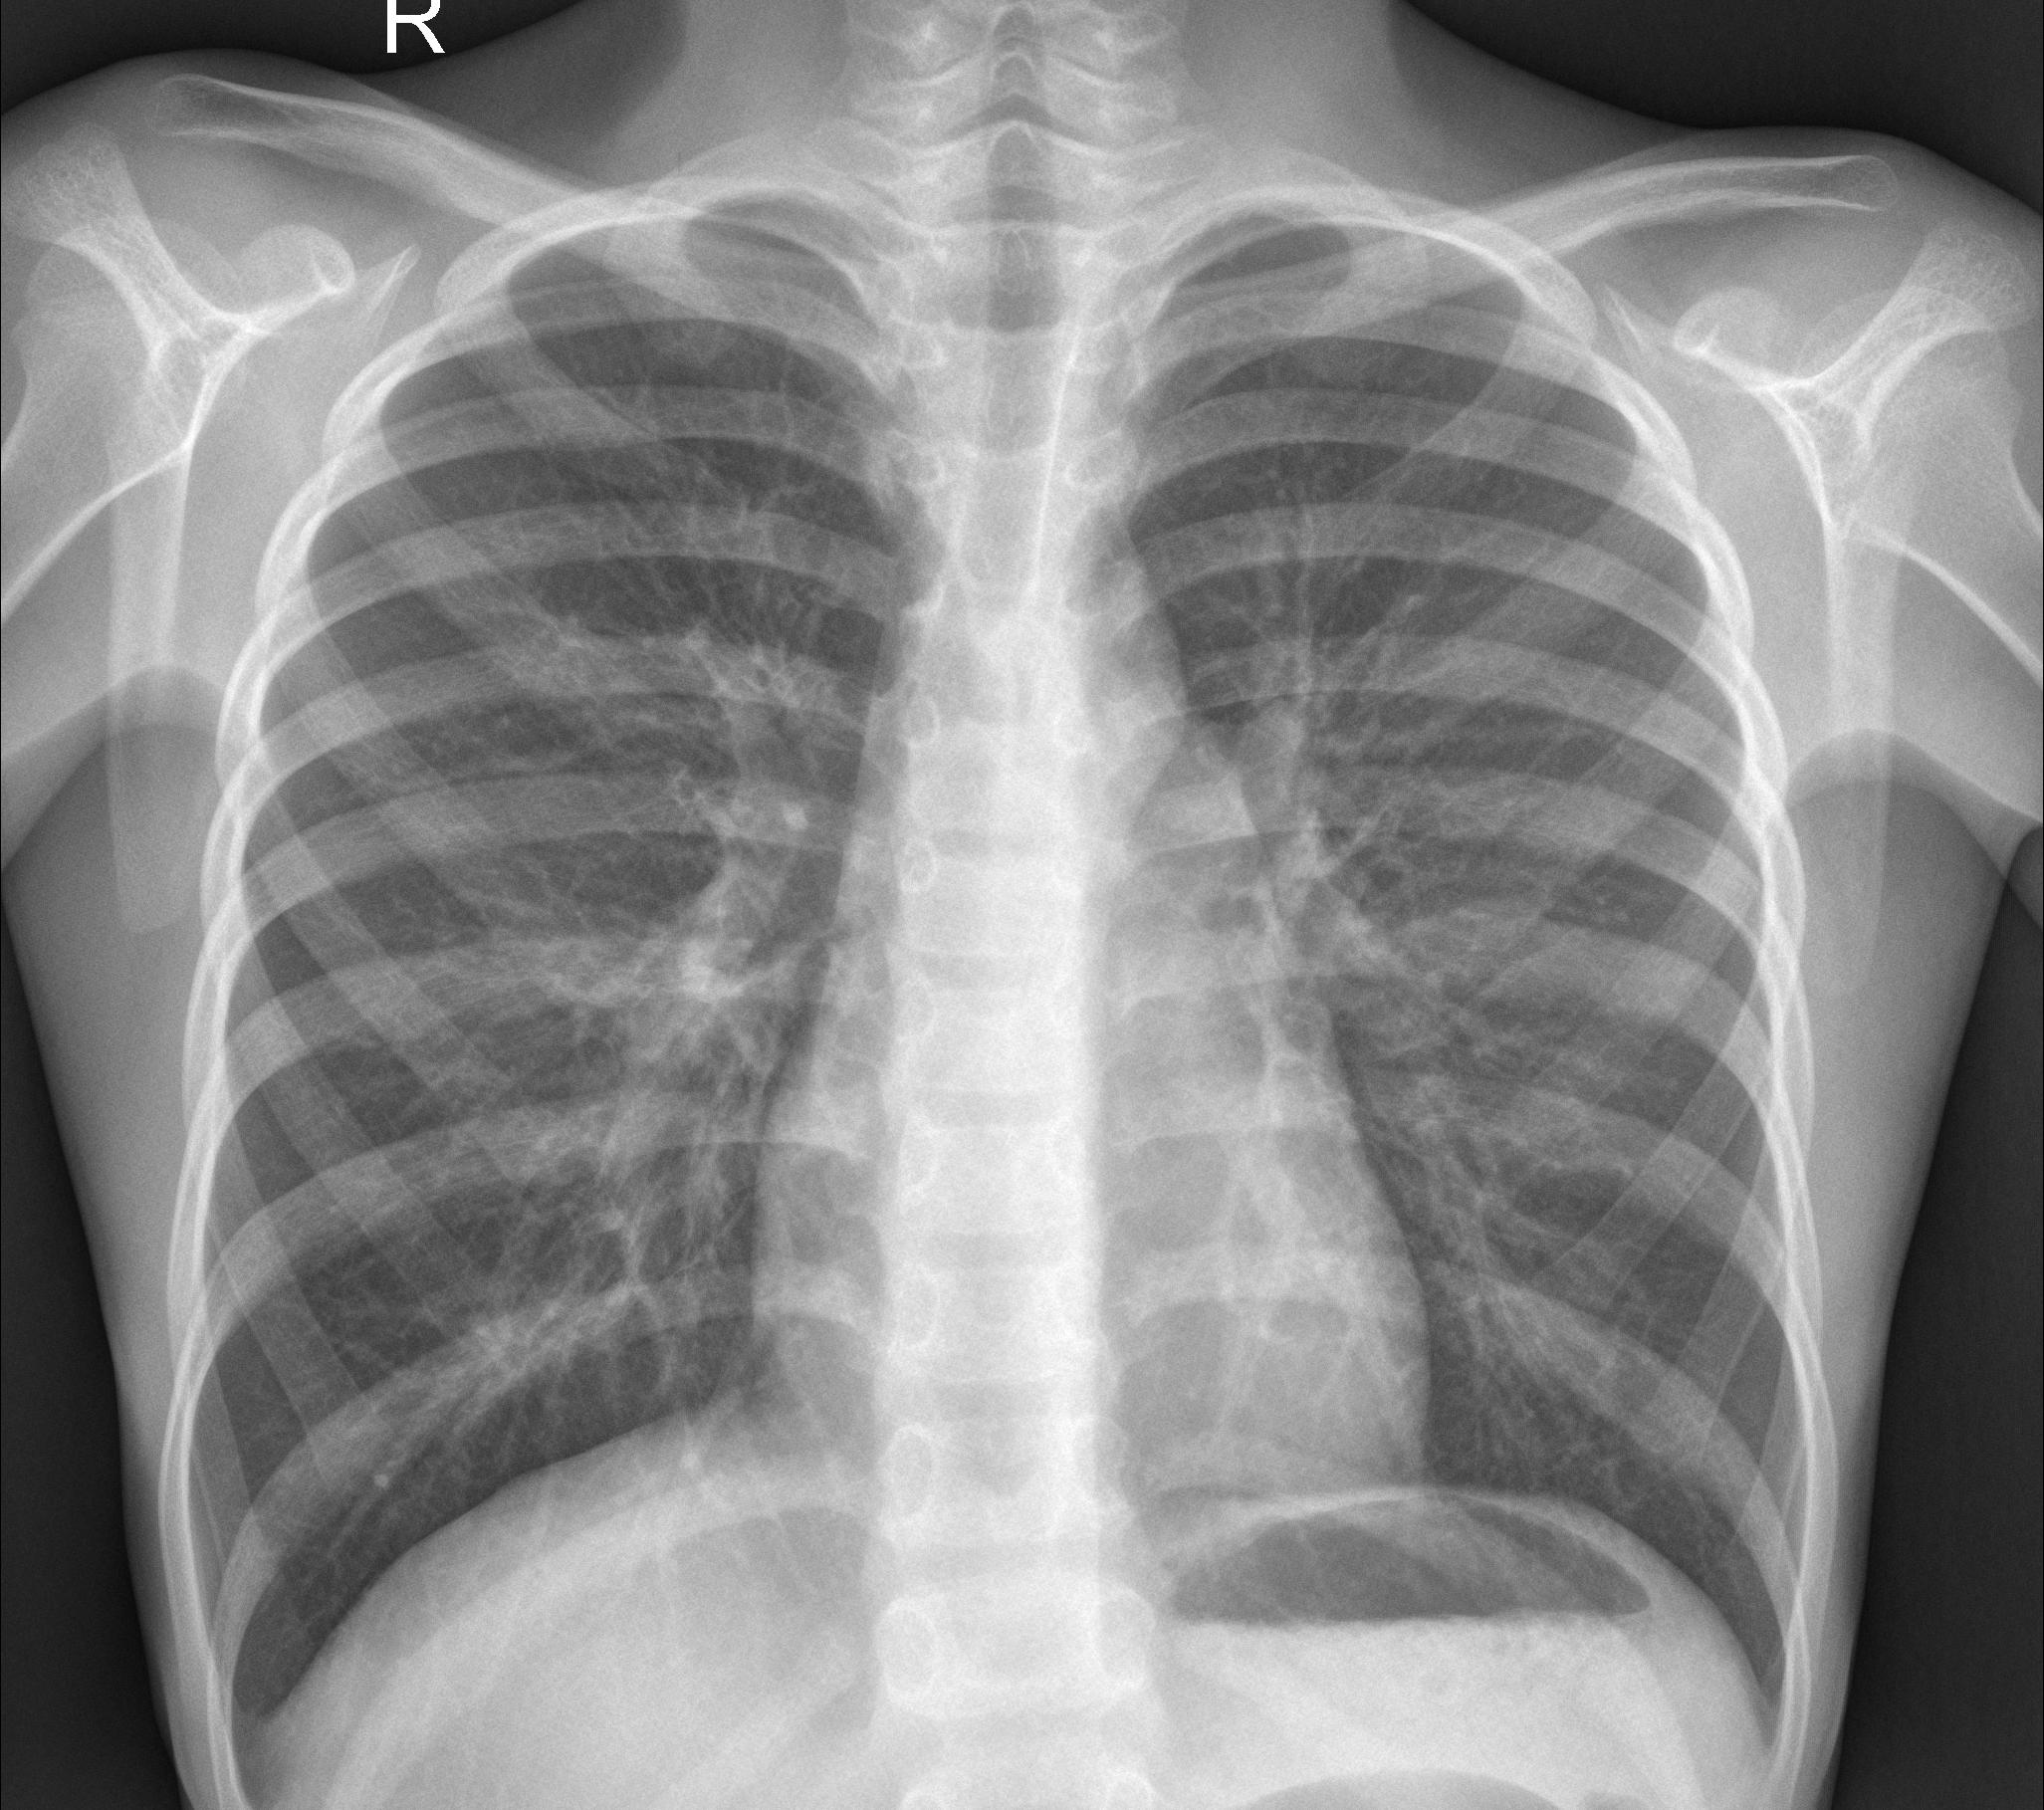

In [30]:
from PIL import Image
with Image.open('chest_xray/test/NORMAL/testing.jpeg') as im:
    display(im)

### Transformations

(2053, 1818)


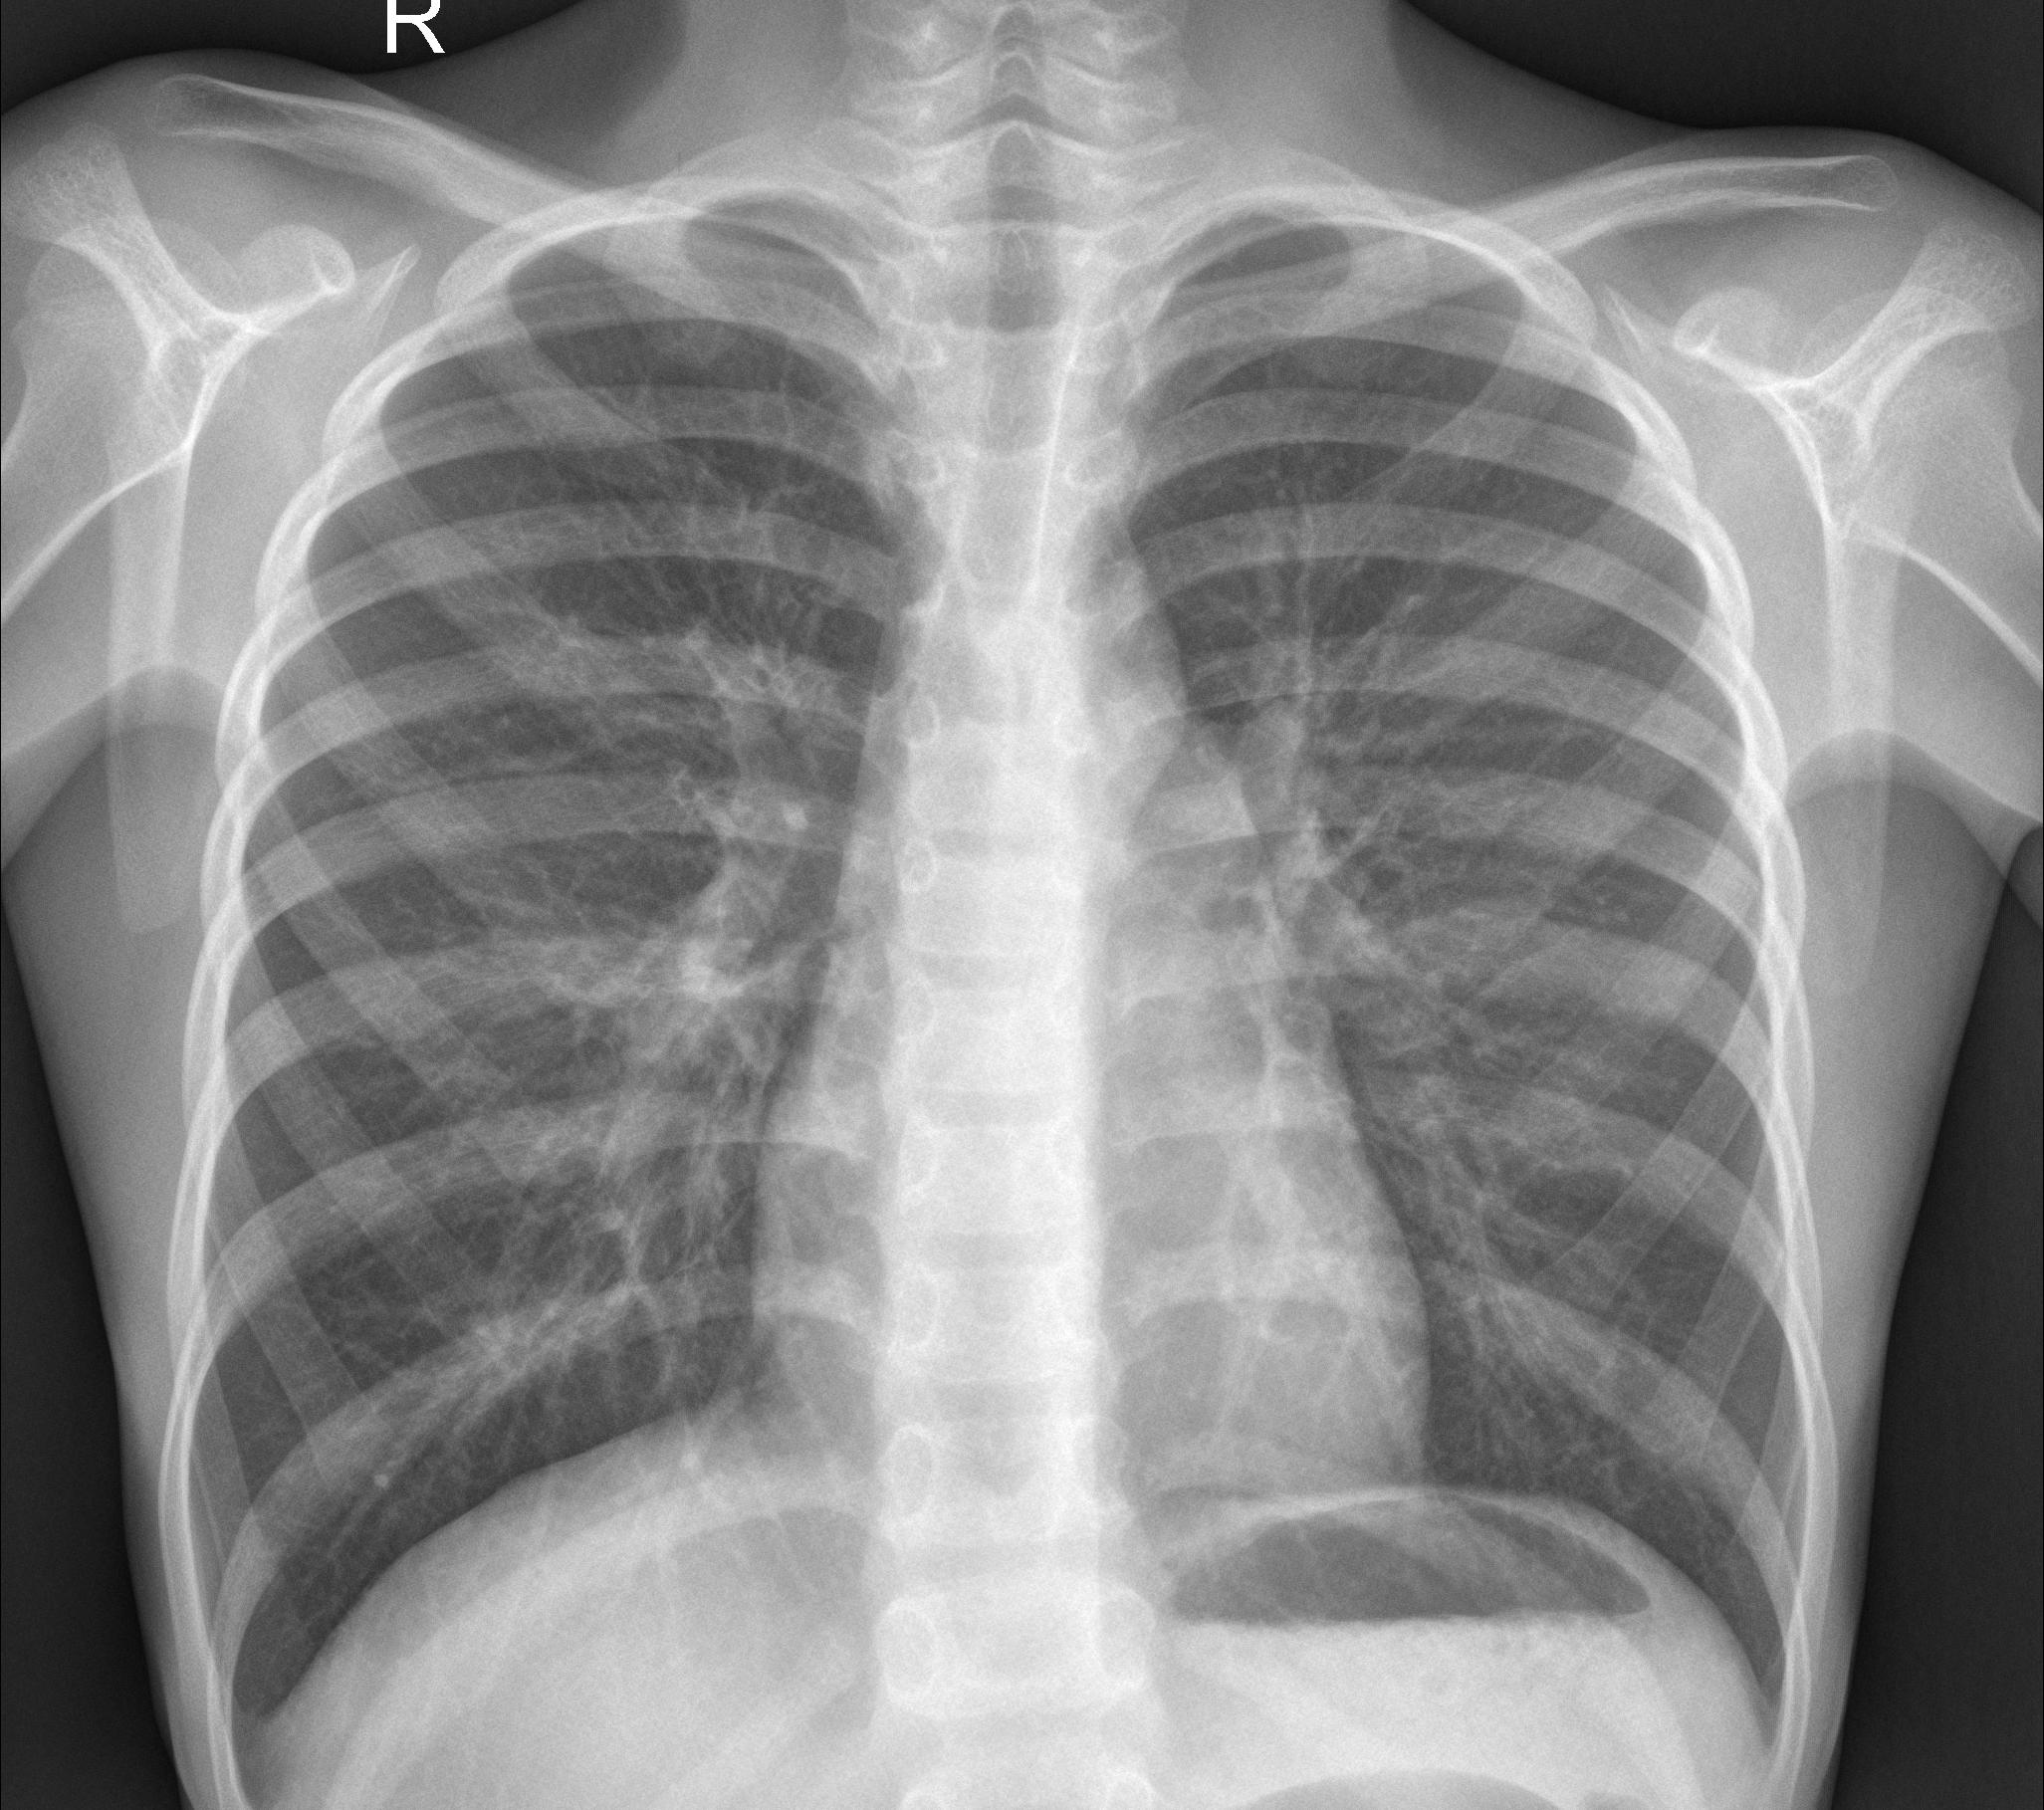

In [31]:
NormalXray = Image.open('chest_xray/test/NORMAL/testing.jpeg')
print(NormalXray.size)
display(NormalXray)

### Transforms.toTensor

torch.Size([1, 1818, 2053])


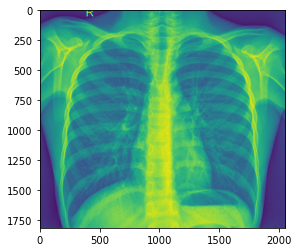

In [34]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor()
])
im = transform(NormalXray)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [35]:
im[:,0,0]

tensor([0.])

In [24]:
#Let's look at an example of an image in its tensor form. 
#Note that after being loaded, each image is now [3, 224, 224], 
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

### transforms.Resize

torch.Size([1, 224, 252])


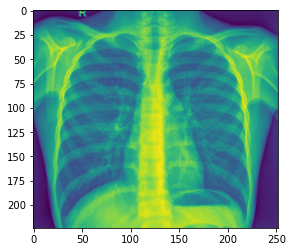

In [36]:
transform = transforms.Compose([
    transforms.Resize(224), 
    transforms.ToTensor()
])
im = transform(NormalXray)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### this resized the shortest side, and scaled the other. let's try this on a small image

(1292, 751)


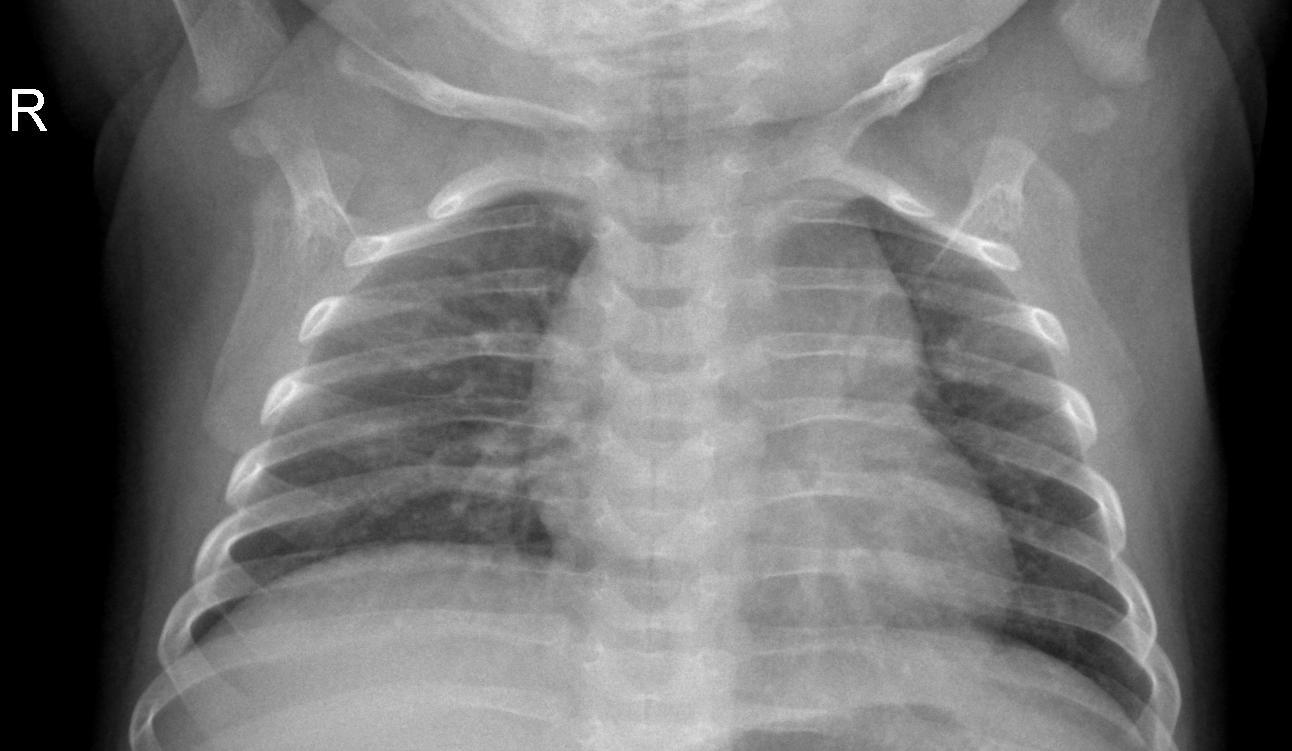

In [37]:
smallSize = Image.open('chest_xray/test/NORMAL/smallSize.jpeg')
print(smallSize.size)
display(smallSize)

torch.Size([1, 751, 1292])


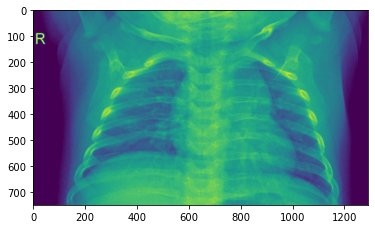

In [55]:
im = transform(smallSize)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### transforms.centercrop(size)

torch.Size([1, 224, 224])


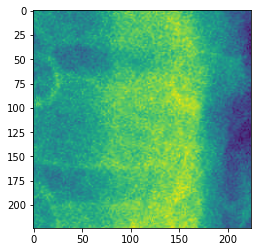

In [39]:
transform = transforms.Compose([
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(NormalXray) # this crops the original image
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### its be better to resize the image first then crop, so first resize then

torch.Size([1, 224, 224])


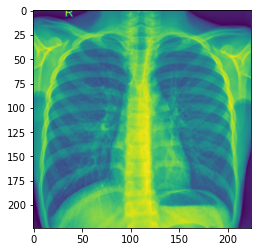

In [40]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(NormalXray)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### transforms.randomHorizontalFilip (p=0.5)

torch.Size([1, 1818, 2053])


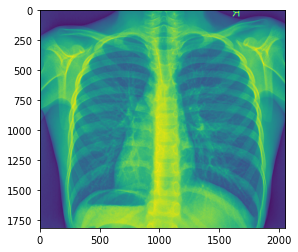

In [41]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.ToTensor()
])
im = transform(NormalXray)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### transforms.random rotation (degrees)

torch.Size([1, 1818, 2053])


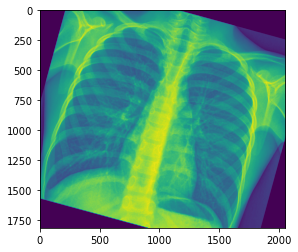

In [43]:
transform = transforms.Compose([
    transforms.RandomRotation(30),  # rotate randomly between +/- 30 degrees
    transforms.ToTensor()
])
im = transform(NormalXray)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### scaling using transforms.resize

torch.Size([1, 224, 224])


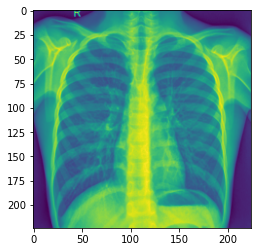

In [44]:
transform = transforms.Compose([
    transforms.Resize((224,224)),  # be sure to pass in a list or a tuple
    transforms.ToTensor()
])
im = transform(NormalXray)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### now let's put it all together

torch.Size([1, 224, 224])


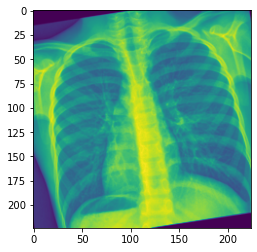

In [45]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),  # normally we'd set p=0.5
    transforms.RandomRotation(30),
    transforms.Resize(224),
    transforms.CenterCrop(224), 
    transforms.ToTensor()
])
im = transform(NormalXray)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Normalization

torch.Size([1, 1818, 2053])


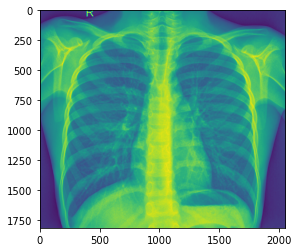

In [50]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1],
                         [0.09])
])
im = transform(NormalXray)
print(im.shape)
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [51]:
#after normalization
im[:,0,0]

tensor([-1.1111])

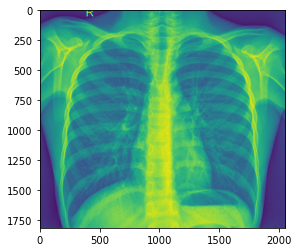

In [53]:
#De-normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, ],
    std=[1/0.224]
)
im_inv = inv_normalize(im)
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

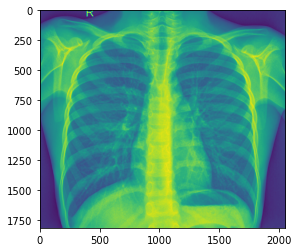

In [54]:
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

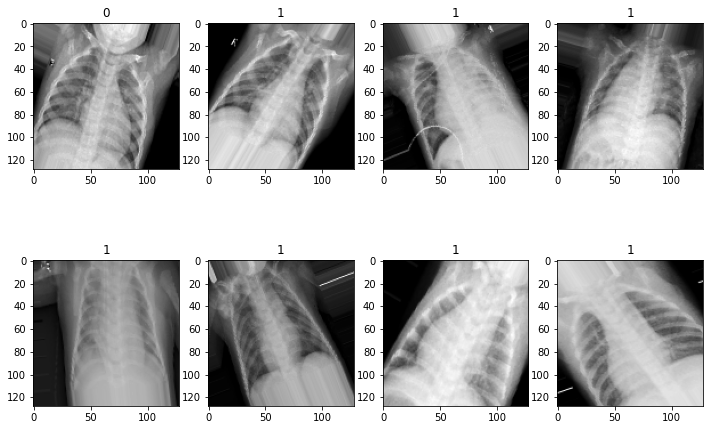

In [25]:
i=0
for batch in train_generator:
    plt.figure(figsize=(12,8))
    for j in range(8):
        plt.subplot(2,4,j+1)
        imgplot = plt.imshow(image.array_to_img(batch[0][j]),cmap = 'gray')
        plt.title(batch[1][j])
 
    i+=1
    if i != 0:
        break
        
plt.show()

In [26]:
print(dataset.classes)

['NORMAL', 'PNEUMONIA']


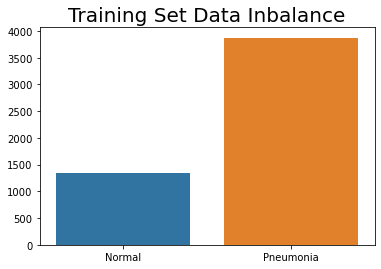

In [27]:
# number of images for each class

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

Label:  NORMAL (0)


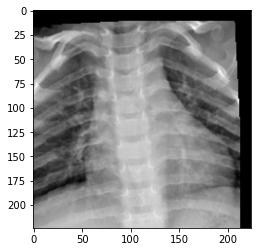

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline 

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))
    
show_example(*dataset[4])

In [29]:
# Function for plotting samples
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

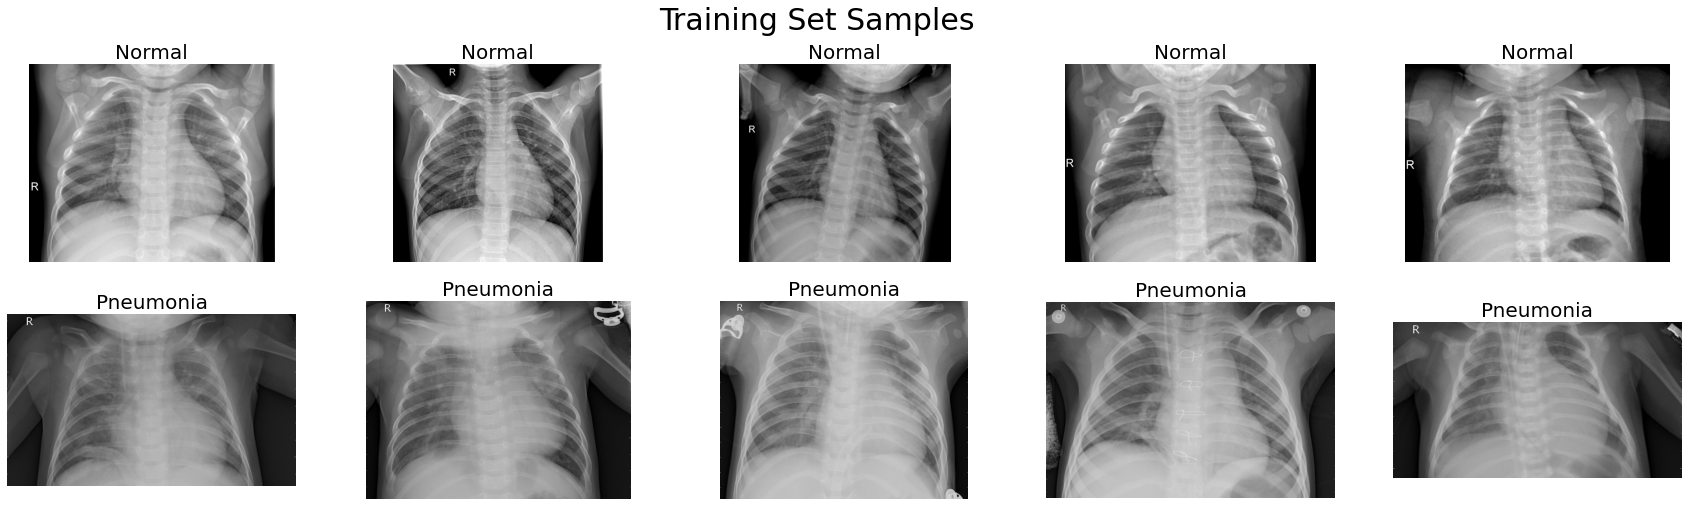

In [30]:
## Plot training samples
rand_samples = random.sample([os.path.join(data_dir+'/train/NORMAL', filename) 
                              for filename in os.listdir(data_dir+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(data_dir+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Training Set Samples', fontsize=30)
plt.show()

<a id='6'></a>
# Preparing train, validation and test data

In [32]:
# set random seed so we get the same sampling every time for reproducibility

random_seed = 2020
torch.manual_seed(random_seed);

In [33]:
train_size = round(len(dataset)*0.7) # 70%
val_size = len(dataset) - train_size # 30%

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(3651, 1565)

In [34]:
batch_size=32

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [86]:
batch_size=4

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

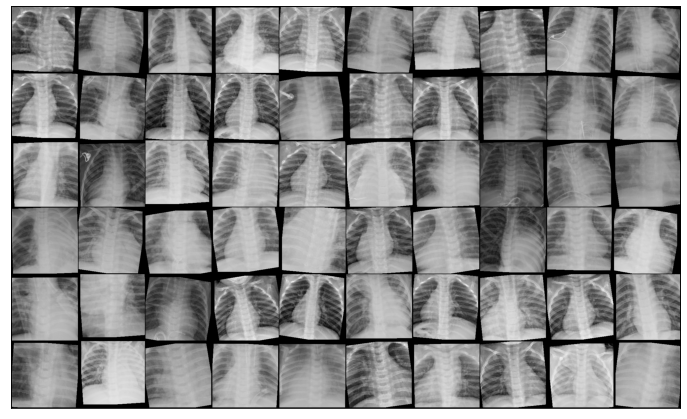

In [35]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

<a id='7'></a>
# Setup the GPU

In [36]:
torch.cuda.is_available()

True

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [82]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cpu')
    else:
        return torch.device('cuda')
    
device = get_default_device()
device

device(type='cpu')

In [38]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [39]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device) # yield will stop here, perform other steps, and the resumes to the next loop/batch

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

<a id='8'></a>
# CNN model building and creating model class

In [41]:
model = Sequential()

model.add(Conv2D(32,(3,3),padding = 'same',activation='relu',input_shape = train_X.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256,(3,3),padding = 'same',activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))



model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [43]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

def F1_score(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    
    # precision, recall, and F1
    cm  = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*((precision*recall)/(precision+recall))
    
    return precision,recall,f1,preds

In [44]:
class PneumoniaModelBase(nn.Module):
    
    # this is for loading the batch of train image and outputting its loss, accuracy 
    # & predictions
    def training_step(self, batch, weight):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels, weight=weight)      # weighted compute loss
        acc,preds = accuracy(out, labels)                       # calculate accuracy
        
        return {'train_loss': loss, 'train_acc':acc}
       
    # this is for computing the train average loss and acc for each epoch
    def train_epoch_end(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]       # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['train_acc'] for x in outputs]          # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
    # this is for loading the batch of val/test image and outputting its loss, accuracy, 
    # predictions & labels
    def validation_step(self, batch):
        images,labels = batch
        out = self(images)                                      # generate predictions
        loss = F.cross_entropy(out, labels)                     # compute loss
        acc,preds = accuracy(out, labels)                       # calculate acc & get preds
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}
    # detach extracts only the needed number, or other numbers will crowd memory
    
    # this is for computing the validation average loss and acc for each epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]         # get all the batches loss
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]            # get all the batches acc
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    # this is for printing out the results after each epoch
    def epoch_end(self, epoch, train_result, val_result):
        print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.
              format(epoch+1, train_result['train_loss'], train_result['train_acc'],
                     val_result['val_loss'], val_result['val_acc']))
    
    # this is for using on the test set, it outputs the average loss and acc, 
    # and outputs the predictions
    def test_prediction(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()              # combine accuracies
        # combine predictions
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combine labels
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0

In [46]:
model.compile(loss = 'binary_crossentropy',  
              optimizer = optimizers.Adam(lr=1e-4),
              metrics = ['accuracy'] )

In [47]:
#callbacks 
callbacks_list = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20),
                  ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
                 ]
 

In [48]:
history = model.fit_generator(train_generator,
                             steps_per_epoch = (train_X.shape[0]//32), 
                             epochs=100,
                             verbose=2,
                             validation_data=test_generator,
                             validation_steps = (test_X.shape[0]//32),
                             callbacks = callbacks_list
                            )



Epoch 1/100
163/163 - 182s - loss: 0.3519 - accuracy: 0.8618 - val_loss: 2.6190 - val_accuracy: 0.6299
Epoch 2/100
163/163 - 181s - loss: 0.2313 - accuracy: 0.9126 - val_loss: 3.3826 - val_accuracy: 0.6266
Epoch 3/100
163/163 - 182s - loss: 0.1896 - accuracy: 0.9254 - val_loss: 3.6819 - val_accuracy: 0.6283

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 4/100
163/163 - 195s - loss: 0.1687 - accuracy: 0.9358 - val_loss: 1.8960 - val_accuracy: 0.6283
Epoch 5/100
163/163 - 179s - loss: 0.1702 - accuracy: 0.9327 - val_loss: 0.9215 - val_accuracy: 0.7105
Epoch 6/100
163/163 - 183s - loss: 0.1677 - accuracy: 0.9394 - val_loss: 0.6426 - val_accuracy: 0.8043
Epoch 7/100
163/163 - 182s - loss: 0.1572 - accuracy: 0.9411 - val_loss: 0.6177 - val_accuracy: 0.8076
Epoch 8/100
163/163 - 181s - loss: 0.1530 - accuracy: 0.9427 - val_loss: 0.4116 - val_accuracy: 0.8635
Epoch 9/100
163/163 - 181s - loss: 0.1522 - accuracy: 0.9436 - val_loss: 0.5348 - val_accuracy

<a id='9'></a>
# Data Visualization

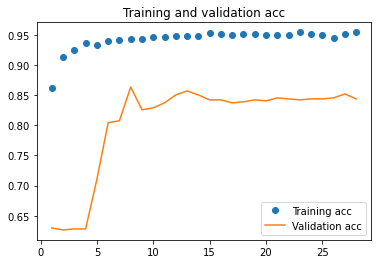

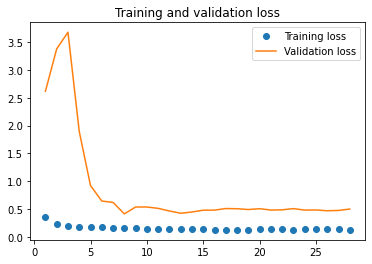

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'o',label='Training acc')
plt.plot(epochs,val_acc,label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'o',label='Training loss')
plt.plot(epochs,val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



In [51]:
model.evaluate(test_generator)

20/20 [==============================] - 3s 135ms/step - loss: 0.5031 - accuracy: 0.8413


[0.5030701756477356, 0.8413461446762085]

<a id='10'></a>
# Using VGG-16 Model

In [52]:
from keras.applications import VGG16

In [53]:
image_size = 256

In [54]:
#download vgg16 from tensorflow keras application
vgg_model = VGG16(input_shape= (image_size, image_size,3), 
                  weights='imagenet',
                  include_top=False)

# for the first time https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [55]:
vgg_model.trainable = False

In [56]:
transfer_model = Sequential()
transfer_model.add(vgg_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(512,activation='relu'))
transfer_model.add(Dense(128,activation='relu'))
transfer_model.add(Dense(1,activation='sigmoid'))



In [57]:
transfer_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 31,558,209
Trainable params: 16,843,521
Non-trainable params: 14,714,688
_________________________________________________________________


In [58]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size = (image_size,image_size),
                                                    class_mode = 'binary',
                                                    batch_size=32 , 
                                                    shuffle=True , 
                                                    seed=123 )



Found 5216 images belonging to 2 classes.


In [59]:
test_generator = test_datagen.flow_from_directory(test_dir , 
                                                    target_size = (image_size,image_size),
                                                    class_mode = 'binary',
                                                    batch_size=32 , 
                                                    shuffle=True , 
                                                    seed=123 )

Found 624 images belonging to 2 classes.


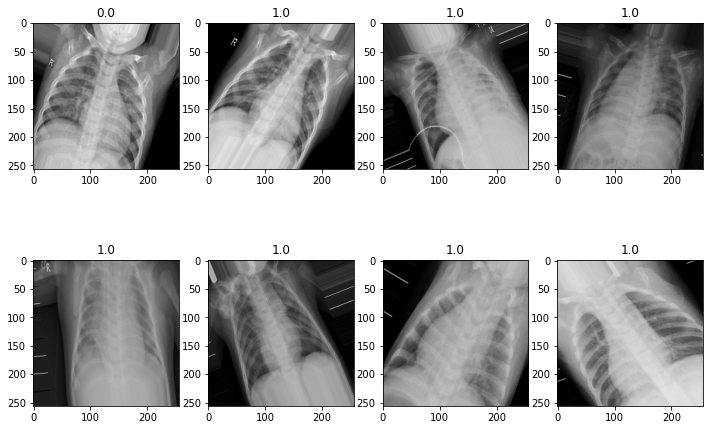

In [60]:
i=0
for batch in train_generator:
    plt.figure(figsize=(12,8))
    for j in range(8):
        
        plt.subplot(2,4,j+1)
        imgplot = plt.imshow(image.array_to_img(batch[0][j]))
        plt.title(batch[1][j])

 
    i+=1
    if i != 0:
        break
        
plt.show()


In [61]:
transfer_model.compile(loss = 'binary_crossentropy', 
                          optimizer = 'adam',
                          metrics = ['accuracy'] )



In [62]:
history = transfer_model.fit_generator(train_generator,
                                         steps_per_epoch = (train_X.shape[0]//32), 
                                         epochs=100,
                                         verbose=2,
                                         validation_data=test_generator,
                                         validation_steps = (test_X.shape[0]//32),
                                         callbacks = callbacks_list
                                        )

Epoch 1/100
163/163 - 1598s - loss: 0.2860 - accuracy: 0.8992 - val_loss: 0.4280 - val_accuracy: 0.8668
Epoch 2/100
163/163 - 1453s - loss: 0.1519 - accuracy: 0.9427 - val_loss: 0.3135 - val_accuracy: 0.8882
Epoch 3/100
163/163 - 1583s - loss: 0.1471 - accuracy: 0.9423 - val_loss: 0.2249 - val_accuracy: 0.9227
Epoch 4/100
163/163 - 1539s - loss: 0.1252 - accuracy: 0.9530 - val_loss: 0.3046 - val_accuracy: 0.8618
Epoch 5/100
163/163 - 1484s - loss: 0.1047 - accuracy: 0.9620 - val_loss: 0.2637 - val_accuracy: 0.9112

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/100
163/163 - 1497s - loss: 0.0828 - accuracy: 0.9684 - val_loss: 0.2181 - val_accuracy: 0.9161
Epoch 7/100
163/163 - 1529s - loss: 0.0834 - accuracy: 0.9670 - val_loss: 0.2084 - val_accuracy: 0.9145

Epoch 00007: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 8/100
163/163 - 1652s - loss: 0.0755 - accuracy: 0.9720 - val_loss: 0.2119 - val_accuracy: 0.9095
Epoch 

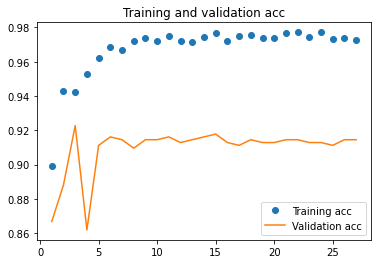

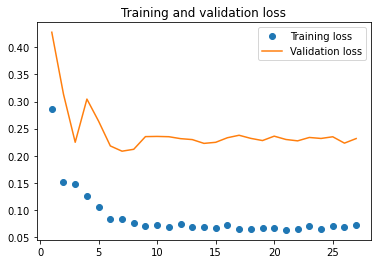

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)
plt.plot(epochs,acc,'o',label='Training acc')
plt.plot(epochs,val_acc,label='Validation acc')
plt.title('Training and validation acc')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'o',label='Training loss')
plt.plot(epochs,val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [64]:
transfer_model.evaluate(test_generator)

20/20 [==============================] - 152s 8s/step - loss: 0.2311 - accuracy: 0.9135


[0.23107925057411194, 0.9134615659713745]

<a id='11'></a>
# Using Resnet-50

In [70]:
#download resnet50 model
resnet50 = models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\rony/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


In [118]:
class PneumoniaResnet(PneumoniaModelBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Freeze training for all layers before classifier
        for param in self.network.fc.parameters():
            param.require_grad = False  
        num_features = self.network.fc.in_features # get number of in features of last layer
        self.network.fc = nn.Linear(num_features, 2) # replace model classifier
    
    def forward(self, xb):
        return self.network(xb)

In [119]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, val_loader, weight, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache() # release all the GPU memory cache
    history = {}

    optimizer = opt_func(model.parameters(), lr)

    best_loss = 1 # initialize best loss, which will be replaced with lower better loss
    for epoch in range(epochs):
        
        # Training Phase 
        model.train() 
        train_outputs = []      
        lrs = []
        
        for batch in train_loader:
            outputs = model.training_step(batch, weight)
            loss = outputs['train_loss']     # get the loss
            train_outputs.append(outputs)
            # get the train average loss and acc for each epoch
            train_results = model.train_epoch_end(train_outputs)                        
            loss.backward()   # compute gradients
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()  # update weights
            optimizer.zero_grad() # reset gradients 
             
            
        
        # Validation phase
        val_results = evaluate(model, val_loader)
        
        # Save best loss
        if val_results['val_loss'] < best_loss and epoch + 1 > 15:
            best_loss = min(best_loss, val_results['val_loss'])
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'best_model.pt')
        
        # print results
        model.epoch_end(epoch, train_results, val_results)
        
        # save results to dictionary
        to_add = {'train_loss': train_results['train_loss'],
                  'train_acc': train_results['train_acc'],
                 'val_loss': val_results['val_loss'],
                  'val_acc': val_results['val_acc'], 'lrs':lrs}
        
        # update performance dictionary
        for key,val in to_add.items():
            if key in history:
                history[key].append(val)
            else:
                history[key] = [val]
    

    
    return history, optimizer, best_loss

<a id='12'></a>
# Train and evaluate model

In [121]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

model = to_device(PneumoniaResnet(), device)

In [122]:
epochs = 5   #for best result set 100
lr = 0.0001
grad_clip = None
weight_decay = 1e-4
opt_func = torch.optim.Adam
# weighted loss for data class imbalance
weight = torch.FloatTensor([3876/(1342+3876), 1342/(1342+3876)]).to(device)

In [123]:
#import torch
#torch.cuda.empty_cache()
#import gc 
#gc.collect()
#i set epochs 5 becuase for one epoch it was taking more than one hours with my 8GB memory
history, optimizer, best_loss = fit(epochs, lr, model, train_dl, val_dl, weight, 
                                    grad_clip=grad_clip, 
                                    weight_decay=weight_decay, 
                                    opt_func=opt_func)



Epoch [1], train_loss: 0.2508, train_acc: 0.9105, val_loss: 0.1309, val_acc: 0.9563
Epoch [2], train_loss: 0.1291, train_acc: 0.9592, val_loss: 0.1500, val_acc: 0.9422
Epoch [3], train_loss: 0.1079, train_acc: 0.9650, val_loss: 0.0758, val_acc: 0.9728
Epoch [4], train_loss: 0.0932, train_acc: 0.9663, val_loss: 0.0816, val_acc: 0.9690
Epoch [5], train_loss: 0.0905, train_acc: 0.9693, val_loss: 0.0786, val_acc: 0.9709


In [124]:
print('Best loss is:', best_loss)

Best loss is: 1


In [125]:
# Save Model
bestmodel = {'model': PneumoniaResnet(),
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}

torch.save(bestmodel, 'PneumoniaResnet.pth')

In [126]:
# this is for loading the model from a previously saved one

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

#model = load_checkpoint('./PneumoniaResnet.pth')

<a id='13'></a>
# Accuracy and loss plots

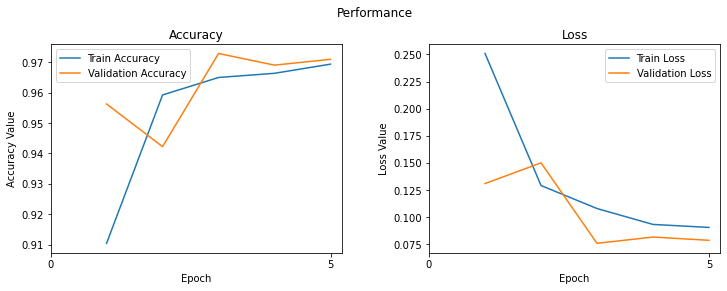

In [127]:
# Plot Accuracy and Loss 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history['train_acc'], label='Train Accuracy')
ax1.plot(epoch_list, history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history['train_loss'], label='Train Loss')
ax2.plot(epoch_list, history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

<a id='14'></a>
# Predicting on the test set

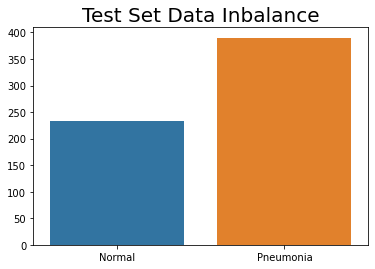

In [128]:
# number of images for each class

test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/test/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Test Set Data Inbalance', fontsize=20)
plt.show()

In [129]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # perform testing for each batch
    outputs = [model.validation_step(batch) for batch in test_loader] 
    results = model.test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

In [130]:
test_dataset = ImageFolder(data_dir+'/test', 
                           transform=tt.Compose([tt.Resize(255),
                                                 tt.CenterCrop(224),                                                              
                                                 tt.ToTensor()
                                                 #tt.Normalize(mean=[0.485, 0.456, 0.406], 
                                                 #             std=[0.229, 0.224, 0.225],
                                                 #             inplace=True)
                                                ]))

In [131]:
# Evaluate test set

test_dl = DataLoader(test_dataset, batch_size=32)
test_dl = DeviceDataLoader(test_dl, device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.3432, test_acc: 0.9062


<a id='15'></a>
# Model Evaluation

<Figure size 432x288 with 0 Axes>

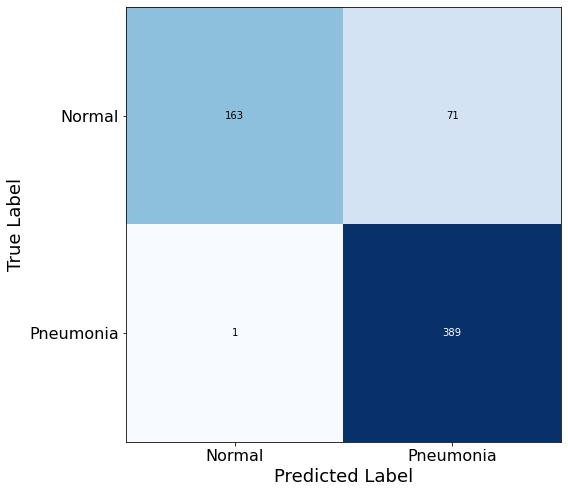

In [132]:
# Plot confusion matrix
cm  = confusion_matrix(labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8),cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.xlabel('Predicted Label',fontsize=18)
plt.ylabel('True Label',fontsize=18)
plt.show()

In [133]:
# Compute Performance Metrics
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("Accuracy of the model is {:.2f}".format(accuracy))
print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))
print("F1 Score of the model is {:.2f}".format(f1))

Accuracy of the model is 0.88
Recall of the model is 1.00
Precision of the model is 0.85
F1 Score of the model is 0.92


<a id='16'></a>
# Plot Predictions against Actual Labels

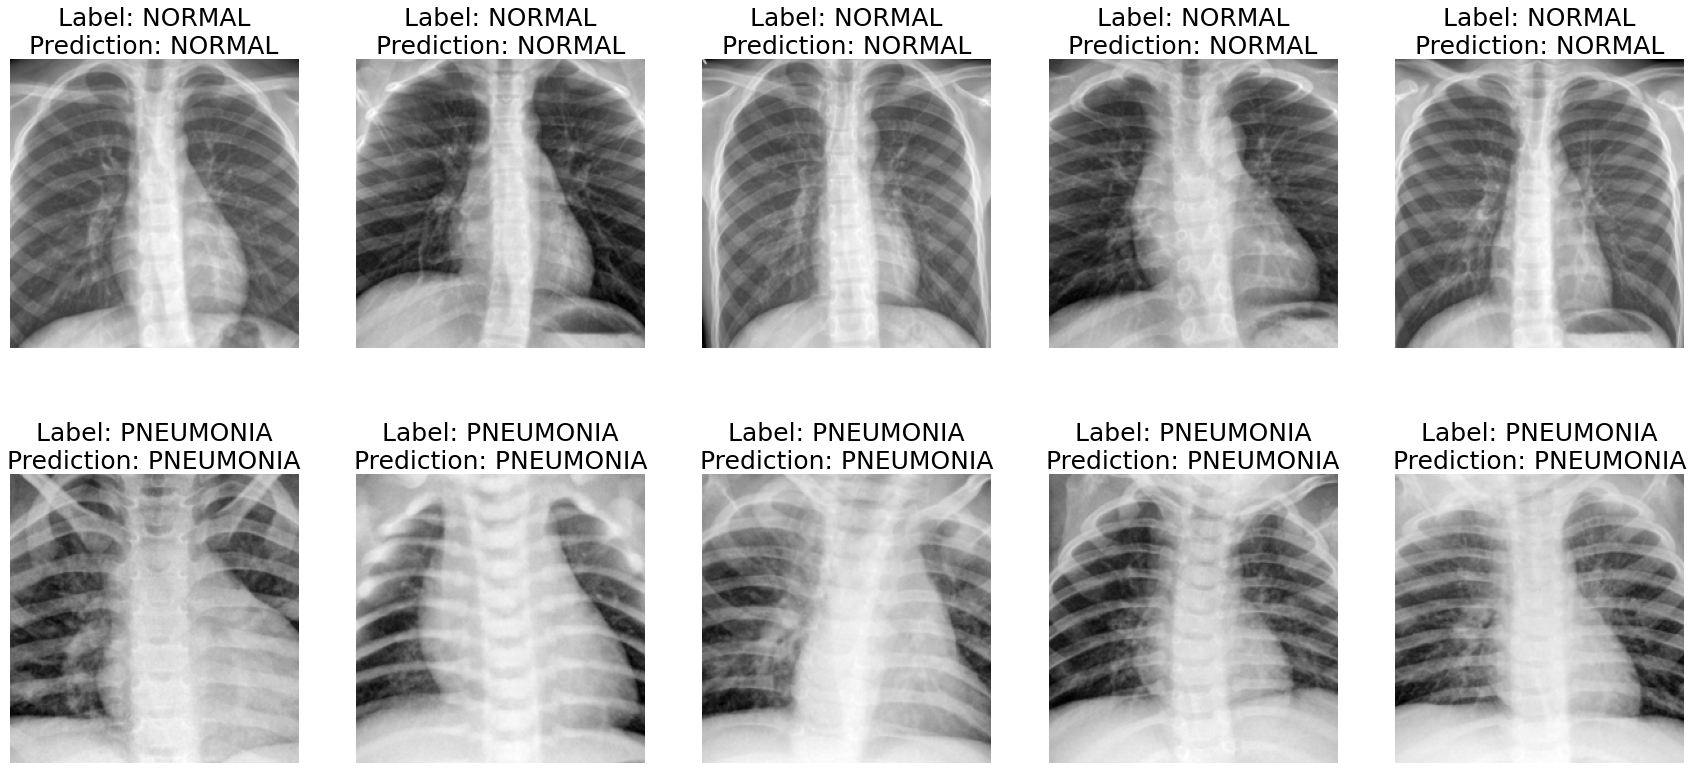

In [134]:
# select 5 normal and 5 pneumonia images indices
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = test_dataset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediction: {}'
                            .format(test_dataset.classes[label], 
                                    test_dataset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

<a id='17'></a>
# The End-thank you~